In [204]:
from qiskit import *
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RZGate, RYGate
import itertools
from itertools import chain


In [205]:
def prefix_probability(d, prefix):
    # count the number of keys in dict starting with given prefix
    tally = 0 
    for key in d.keys():
        if key[:len(prefix)] == prefix:
            tally += np.abs(d[key])**2
    
    norm = get_norm(d)**2
    
    return float(tally/norm)


def get_norm(d):
    norm = 0
    for key in d.keys():
        norm += np.abs( d[key] )**2

    return np.sqrt( norm )

def normalize(d):
    normalized = d.copy()
    for key in d.keys():
        normalized[key] = d[key] / get_norm(d)  
    return normalized
    

def gen_lookup_table(d, n):
    bin_strings = [  ''.join(x)   for x in chain.from_iterable([list( itertools.product(['0','1'], repeat = i ) )  for i in range(1,n+1)  ] ) ] 
    lookup_table = { key  : prefix_probability(d, key) for key in bin_strings }
    return lookup_table

def state_prep_circuit(vect_dict,n):
    
    lookup_table = gen_lookup_table(vect_dict, n)
    
    #padding the vector coefficient table if necessary 
    for key in lookup_table:
        if key not in vect_dict.keys(): 
            vect_dict[key] = 0 
    
    
    qc = QuantumCircuit( n )
    if lookup_table['0'] != 0: 
        qc.ry(  2 * float( np.arctan( np.sqrt( lookup_table['1'] ) / np.sqrt( lookup_table['0'] ) ) )  ,  qc.qubits[0]  ) 
    elif lookup_table['0'] == 0:
        qc.x(0)
            
    for bin_str in lookup_table.keys():
        if ( 1 <= len(bin_str) + 1 <=  n ) and ( lookup_table[bin_str] != 0 ):
            angle = 2* np.arccos( np.sqrt (   lookup_table[bin_str + str(0) ]   ) / np.sqrt(  lookup_table[bin_str]  ) )
            qc.compose( RYGate(float(angle)).control( len(bin_str) , ctrl_state=bin_str[::-1]) , qc.qubits[: len(bin_str) + 1 ]  , inplace=True      )
            
                
        if len(bin_str) == n - 1:
            ## phase, bit string ending in 1 
            angle =  float(  np.angle(vect_dict[ bin_str + '1'])  ) 
            qc.mcp(  angle   , qc.qubits[:len(bin_str)] , qc.qubits[-1]  , ctrl_state=bin_str[::-1])

            
            
            # phase , bit string ending in 0 
            qc.x(n-1) 
            angle =  float(  np.angle(vect_dict[ bin_str + '0'])  ) 
            qc.mcp( angle   , qc.qubits[:len(bin_str)] , qc.qubits[-1]  , ctrl_state=bin_str[::-1])            
            qc.x(n-1)    
            
            
    return qc    
    





{'111': (0.5+0.5j), '011': 0.5j, '100': 0.5}


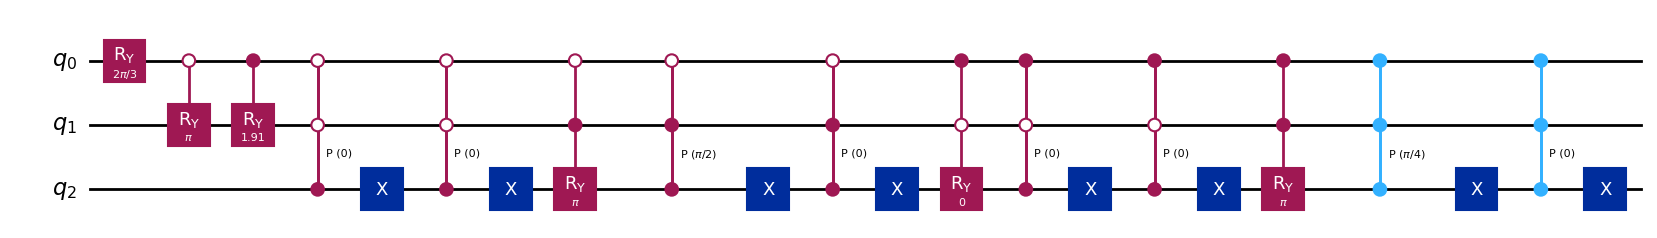

In [206]:
test_vector = { '111' : np.array(  1 + 1j ),  '011': np.array(  0 + 1j ), '100': 1 } 
normalized = normalize(test_vector)

print(normalized) 
qc = state_prep_circuit(test_vector, 3)    
    
qc.draw(output='mpl')

In [207]:
state = Statevector(qc.reverse_bits())
state.draw("Latex")


<IPython.core.display.Latex object>

{'1111': (0.2773500981126146+0.2773500981126146j), '0110': 0.2773500981126146j, '1100': 0.2773500981126146, '0000': 0.8320502943378437}


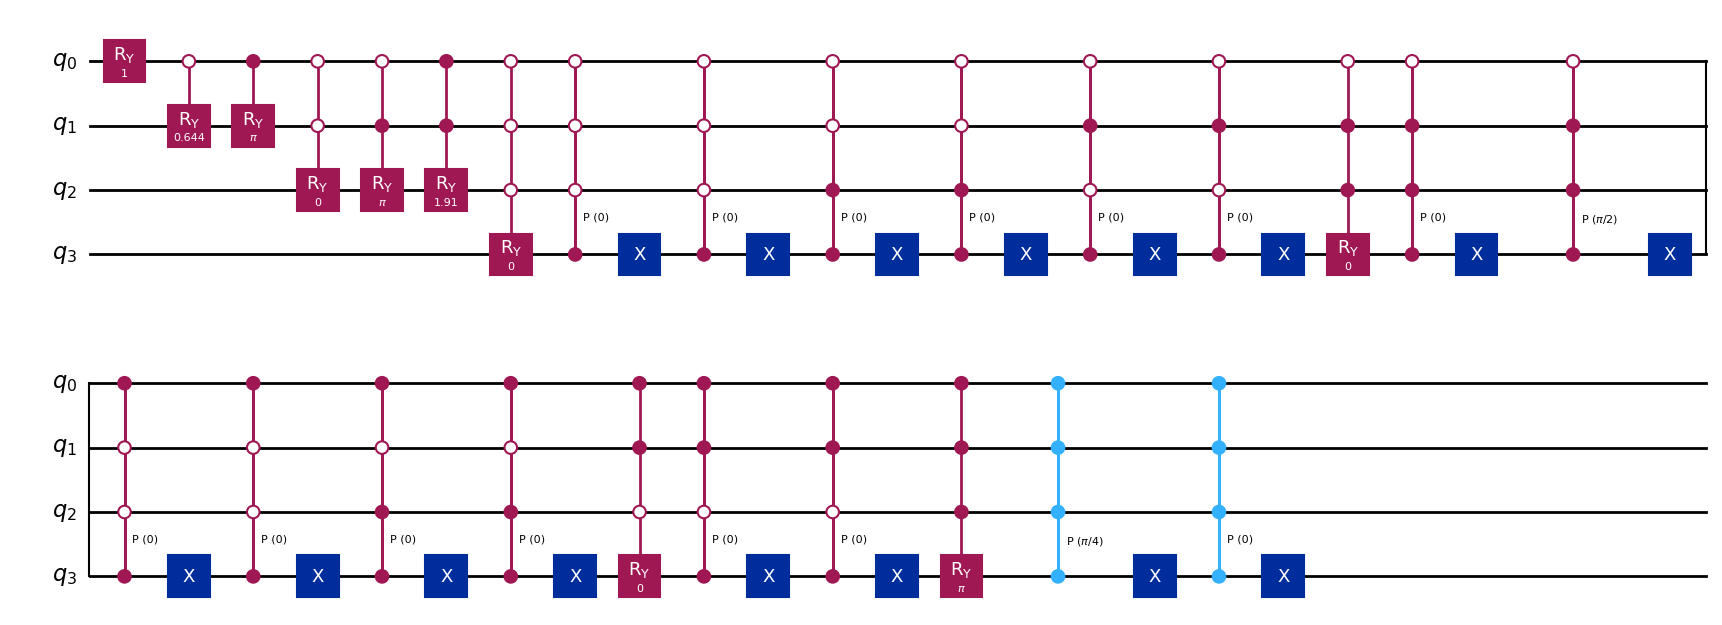

In [208]:
test_vector = { '1111' : np.array(  1 + 1j ),  '0110': np.array(  0 + 1j ), '1100': 1, '0000': 3} 
normalized = normalize(test_vector)

print(normalized) 
qc = state_prep_circuit(test_vector, 4)    
    
qc.draw(output='mpl')

In [209]:
state = Statevector(qc.reverse_bits())
state.draw("Latex")

<IPython.core.display.Latex object>

{'11110': (0.24253562503633297+0.24253562503633297j), '01110': 0.24253562503633297j, '11001': 0.24253562503633297, '00000': 0.7276068751089989, '00011': 0.48507125007266594}


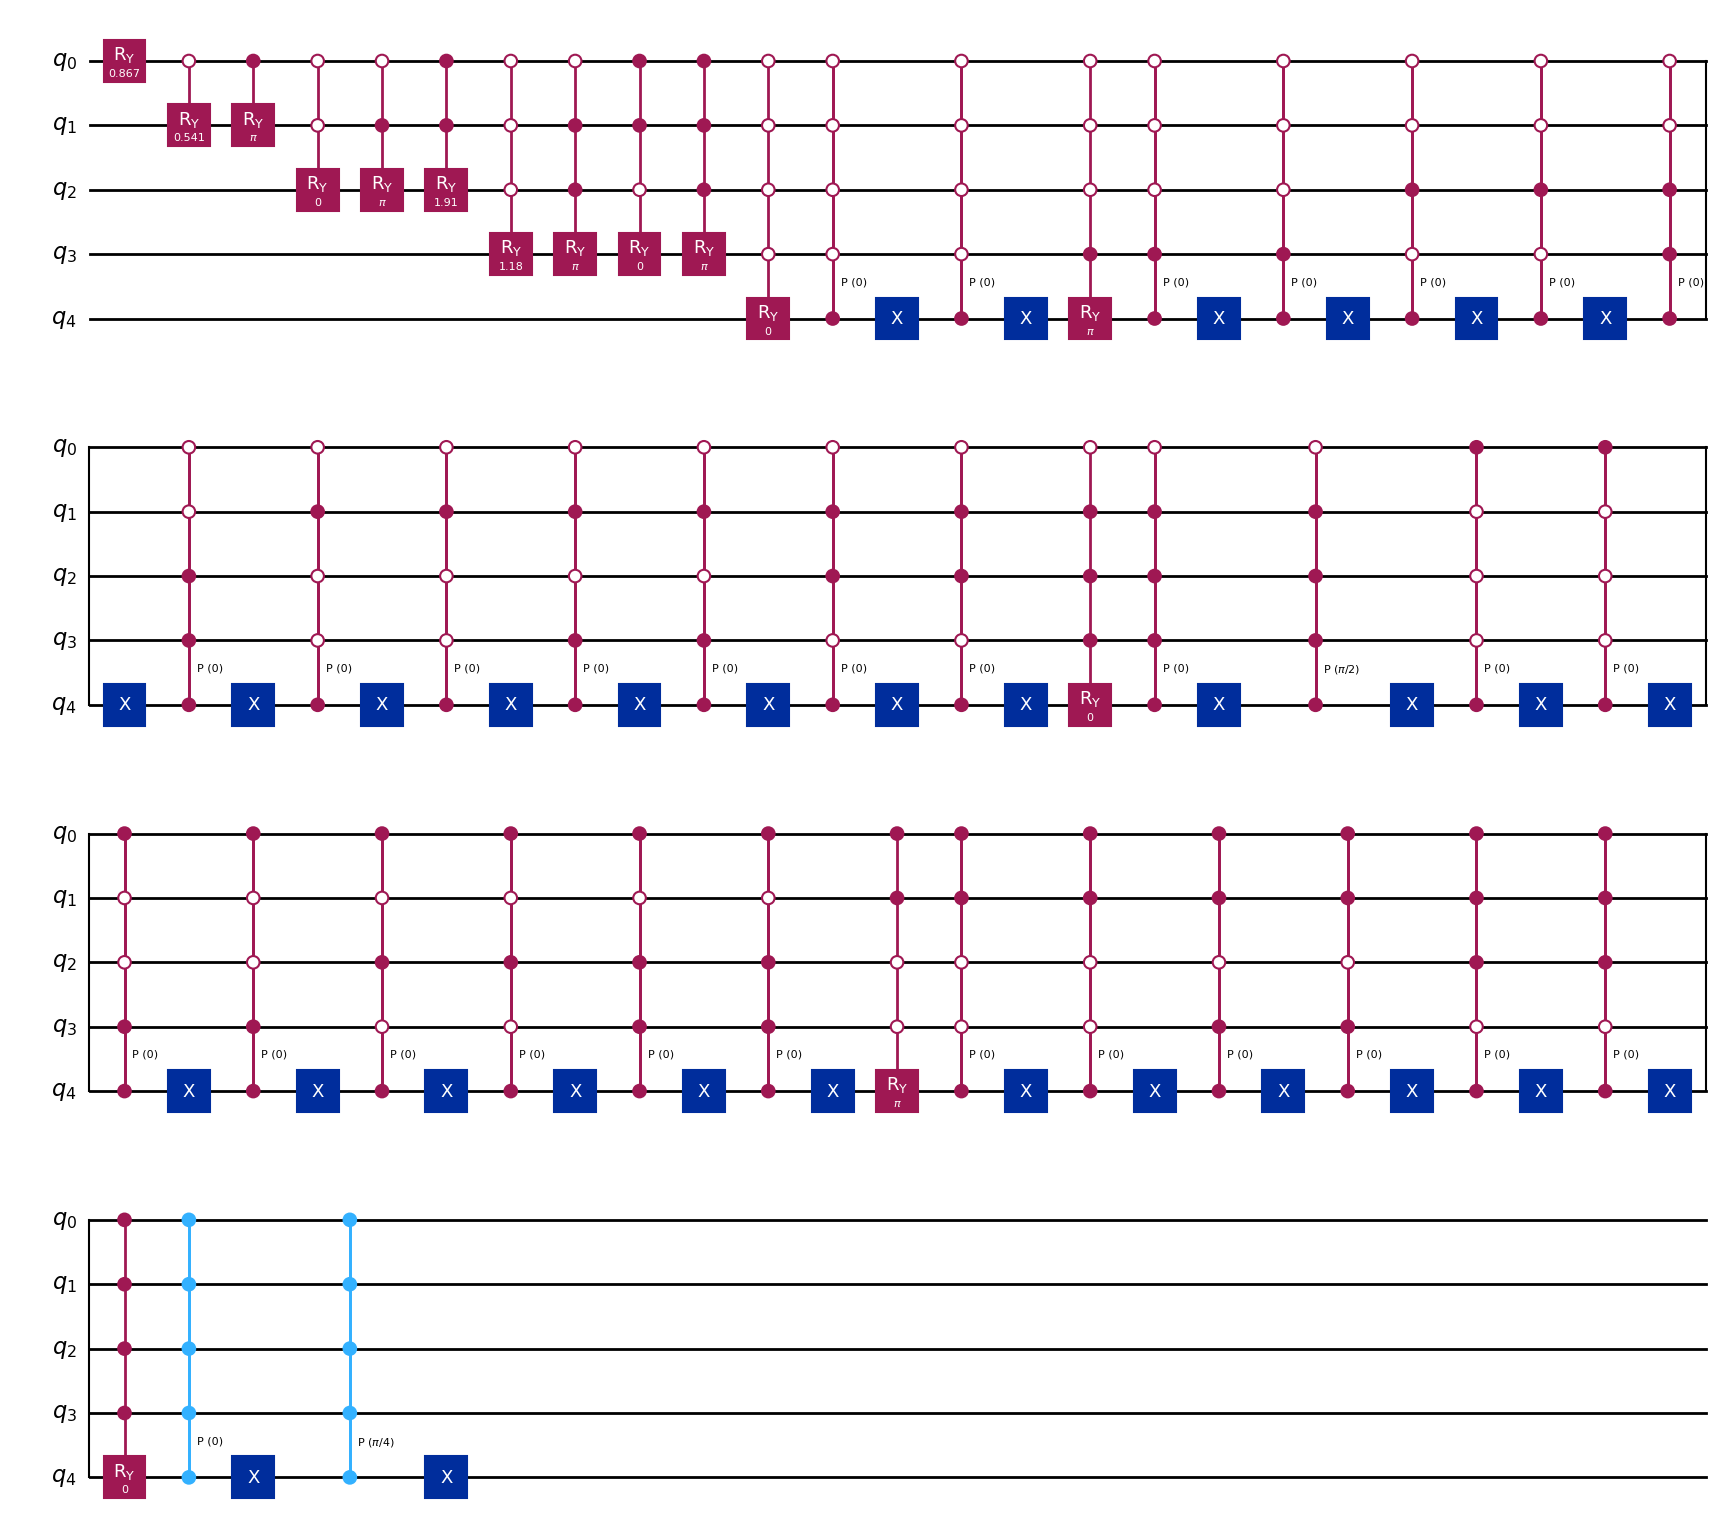

In [210]:
test_vector = { '11110' : np.array(  1 + 1j ),  '01110': np.array(  0 + 1j ), '11001': 1, '00000': 3, '00011' : 2} 
normalized = normalize(test_vector)

print(normalized) 
qc = state_prep_circuit(test_vector, 5)    
    
qc.draw(output='mpl')

In [211]:
state = Statevector(qc.reverse_bits())
state.draw("Latex")

<IPython.core.display.Latex object>